# 1. Import Libraries

In [2]:
import tensorflow as tf
import os

In [3]:
# List available GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')
# Iterate through the list of GPUs
for gpu in gpus:
   # Set memory growth for each GPU to conserve memory
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# List the available GPU devices again to confirm the changes
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [5]:
import cv2 as cv
import imghdr
from matplotlib import pyplot as plt

In [6]:
# Define the path to your 'data' directory in Google Drive
data_dir = '/content/drive/My Drive/Project/Data'

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os

for image_class in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, image_class)
    if os.path.isdir(class_dir):
        for image in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image)
            try:
                img = cv.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issue with image {}'.format(image_path))


# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# **Building the data pipeline**

In [11]:
import tensorflow as tf

data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(128, 128))


Found 795 files belonging to 9 classes.


# **Access the data pipeline**

In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
import matplotlib.pyplot as plt

class_names = ['frocks', 'hoodie', 'saree', 'shirts', 'shoes', 'shorts', 'skirts', 'trousers', 'tshirts']


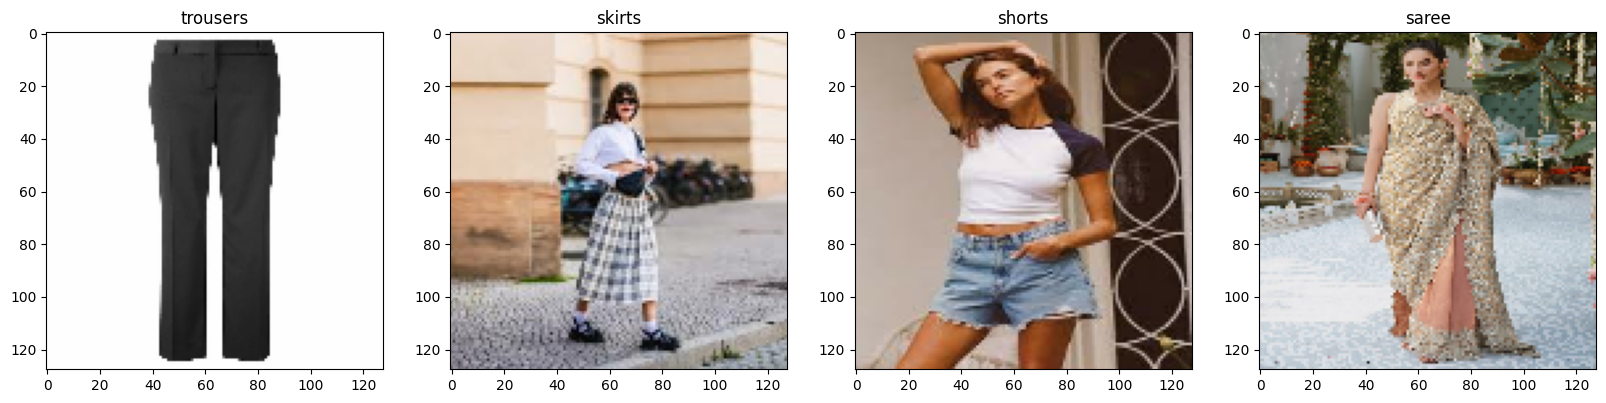

In [15]:

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])  # Set the title with the corresponding class name

plt.show()


# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255.0, y))

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
batch[0].max()

1.0

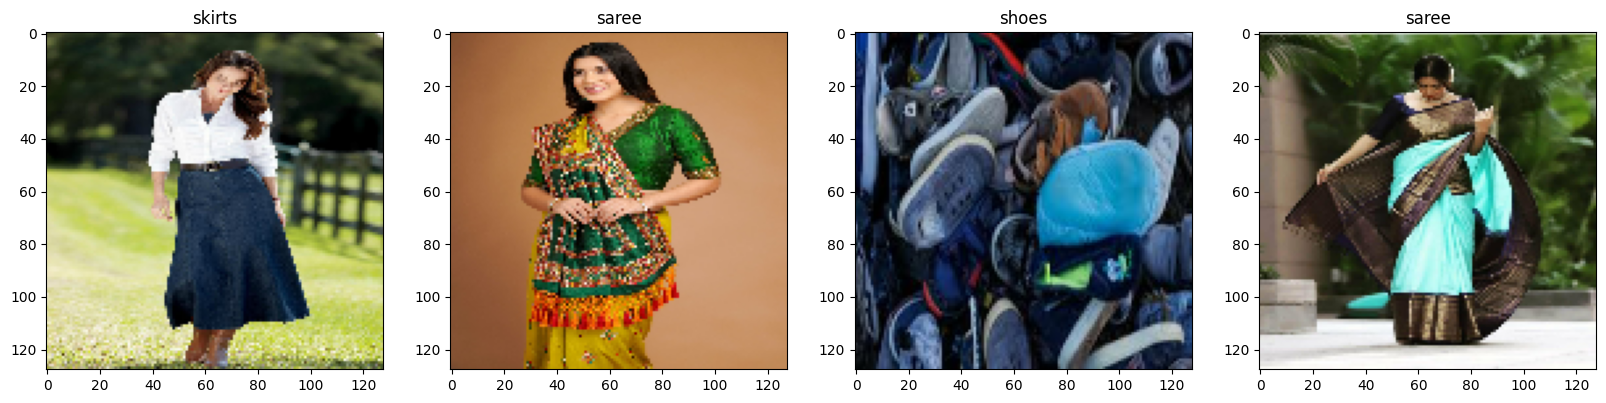

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(class_names[batch[1][idx]])  # Set the title with the corresponding class name

plt.show()


# 5. Split Data

**Number of bateches**

In [21]:
len(data)

25

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [23]:
train_size + test_size + val_size

25

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [25]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [27]:
# Create a sequential model
model = tf.keras.Sequential()

In [96]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)) ) # Adjusted input shape
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))  # Assuming 9 classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [97]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 16)       

# 7. Train

In [98]:
# Define the path to your 'logs' directory in Google Drive
log_dir = '/content/drive/My Drive/Project/logs'

In [99]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [100]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
17/17 [==============================] - 13s 598ms/step - loss: 1.9396 - accuracy: 0.3842 - val_loss: 1.8771 - val_accuracy: 0.4375
Epoch 2/30
17/17 [==============================] - 11s 585ms/step - loss: 1.7493 - accuracy: 0.4577 - val_loss: 1.7694 - val_accuracy: 0.4167
Epoch 3/30
17/17 [==============================] - 10s 512ms/step - loss: 1.7325 - accuracy: 0.4375 - val_loss: 1.6390 - val_accuracy: 0.4792
Epoch 4/30
17/17 [==============================] - 11s 520ms/step - loss: 1.6120 - accuracy: 0.4706 - val_loss: 1.5780 - val_accuracy: 0.4427
Epoch 5/30
17/17 [==============================] - 11s 586ms/step - loss: 1.5067 - accuracy: 0.5110 - val_loss: 1.5092 - val_accuracy: 0.4792
Epoch 6/30
17/17 [==============================] - 9s 489ms/step - loss: 1.3443 - accuracy: 0.5404 - val_loss: 1.2807 - val_accuracy: 0.5833
Epoch 7/30
17/17 [==============================] - 10s 489ms/step - loss: 1.2207 - accuracy: 0.6011 - val_loss: 1.2569 - val_accuracy: 0.5885


# 8. Plot Performance

In [101]:
import matplotlib.pyplot as plt

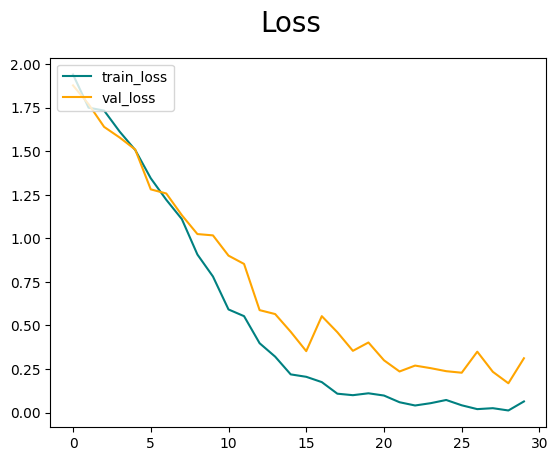

In [102]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='train_loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

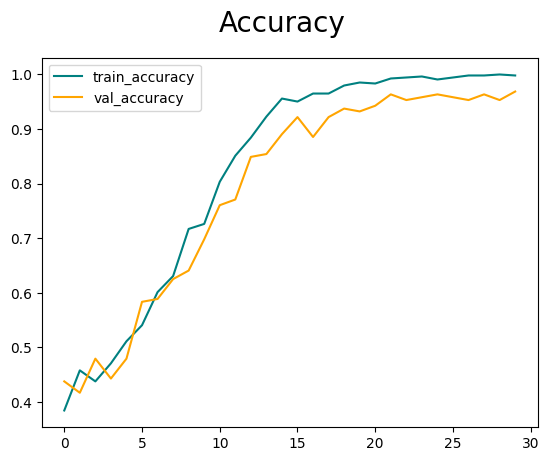

In [103]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='train_accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [104]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

In [105]:
# Initialize metrics
acc = CategoricalAccuracy()
pre = Precision()
re = Recall()

true_labels = []
predicted_labels = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Ensure y and yhat have the correct shapes
    y = tf.one_hot(tf.squeeze(y), depth=9)
    yhat = yhat

    true_labels.extend(np.argmax(y, axis=1))
    predicted_labels.extend(np.argmax(yhat, axis=1))

    # Update the metrics with the current batch
    acc.update_state(y, yhat)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)

# Calculate the final results
accuracy_result = acc.result().numpy()
precision_result = pre.result().numpy()
recall_result = re.result().numpy()

print("Categorical Accuracy:", accuracy_result)
print("Precision:", precision_result)
print("Recall:", recall_result)

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels, labels=range(9))

print("Confusion Matrix:")
print(confusion)



1/1 [==============================] - 0s 73ms/step
Categorical Accuracy: 0.9661017
Precision: 0.9661017
Recall: 0.9661017
Confusion Matrix:
[[31  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 1  0  9  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  1]
 [ 0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  1]]


# 10. Test

In [106]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))

# Assuming 'test' is a TensorFlow dataset
batch_23 = next(test.as_numpy_iterator())  # Get the 23rd batch
batch_24 = next(test.as_numpy_iterator())  # Get the 24th batch

# Make predictions for both batches
predictions_23 = model.predict(batch_23[0])
predictions_24 = model.predict(batch_24[0])

for idx in range(20):
    if idx < 10:
        batch = batch_23
        predictions = predictions_23
        batch_idx = 0
    else:
        batch = batch_24
        predictions = predictions_24
        batch_idx = 1

    row = idx // 5
    col = idx % 5

    ax[row, col].imshow(batch[0][idx - batch_idx * 10])
    actual_name = class_names[batch[1][idx - batch_idx * 10]]
    predicted_name = class_names[np.argmax(predictions[idx - batch_idx * 10])]

    if predicted_name == actual_name:
        label_color = 'green'
    else:
        label_color = 'red'

    ax[row, col].set_title(f"Actual: {actual_name}\nPredicted: {predicted_name}", color=label_color)

plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [107]:
test_loss, test_accuracy = model.evaluate(test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


2/2 [==============================] - 8s 15ms/step - loss: 0.0081 - accuracy: 1.0000
Test Accuracy: 100.00%


# **Train SimCLR on Clothing**

In [109]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

In [110]:
num_workers = 8
batch_size = 64
seed = 1
max_epochs = 20
input_size = 128
num_ftrs = 32

In [111]:
pl.seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Seed set to 1


1

In [112]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)

dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Create the SimCLR Model**

In [113]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [114]:
model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

In [115]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# **Visualize Nearest Neighbors**

In [116]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

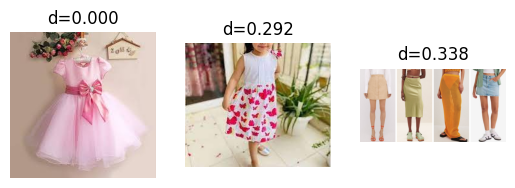

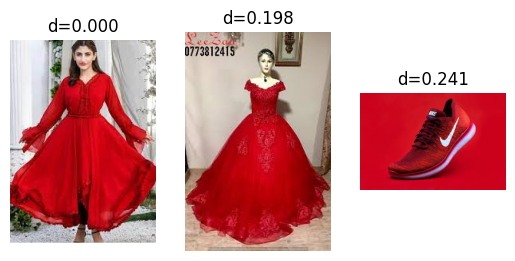

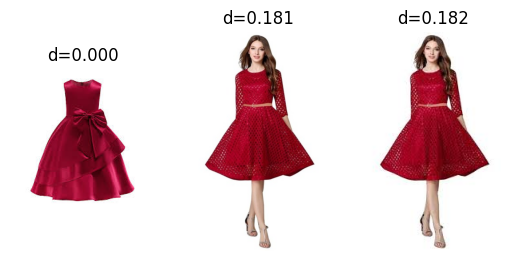

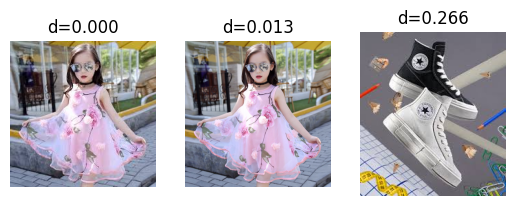

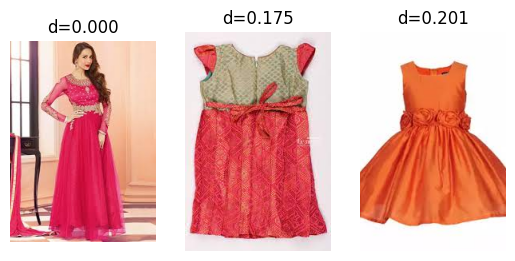

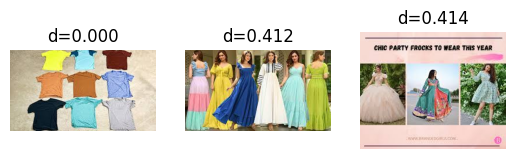

In [148]:
plot_knn_examples(embeddings, filenames)

# **Color Invariance**

In [127]:
# Set color jitter and gray scale probability to 0
new_transform = SimCLRTransform(
    input_size=input_size, vf_prob=0.5, rr_prob=0.5, cj_prob=0.0, random_gray_scale=0.0
)

# let's update the transform on the training dataset
dataset_train_simclr.transform = new_transform

# then train a new model
model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
trainer.fit(model, dataloader_train_simclr)

# and generate again embeddings from the test set
model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: Th

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

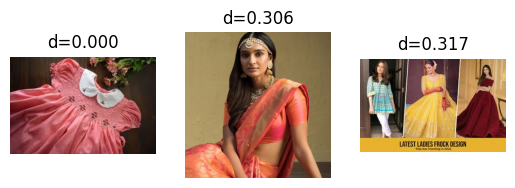

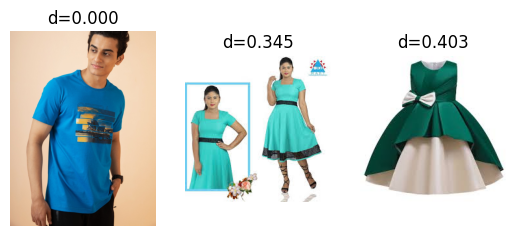

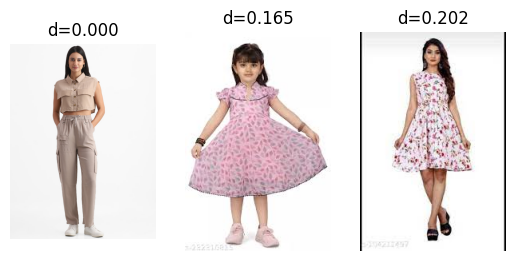

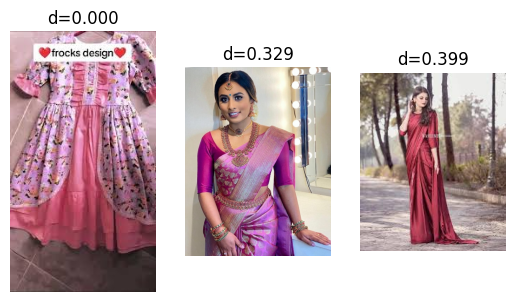

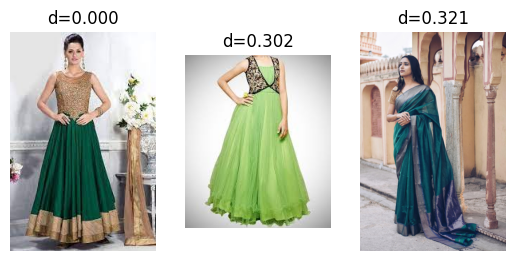

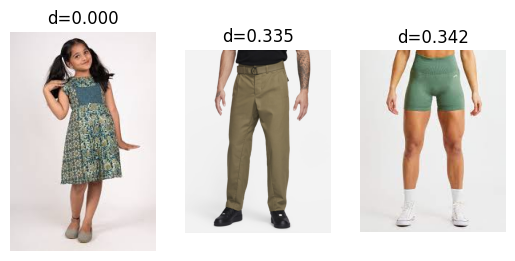

In [140]:
plot_knn_examples(embeddings, filenames)